# Assignment 1. Data Manipulation and Visualization  

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For your questions refer to asoleix@gmail.com or @amirsoleix on Telegram*

### Description
In this homework you are supposed to get comfortable (or make sure that you are!) with the basic Python tools frequently used in data science.  

### Information  
Complete the information box below.

In [1]:
full_name = 'Danial Ataie'
student_id = '99100455'

In [2]:
# Import all your libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import zipfile
import os
import re

In [3]:
# Extract all the zip files
folders = ['./data/bikes', './data//lego']
for folder in folders:
    for file in os.listdir(folder):
        if file.endswith('.zip'):
            with zipfile.ZipFile(folder + '/' + file, 'r') as zip_ref:
                zip_ref.extractall(folder)

## 1. Another LEGO brick in the wall
LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following diagram.

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
* Load your data into `Pandas`  

* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### 1.1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

In [4]:
colors = pd.read_csv('./data/lego/colors.csv')
inventories = pd.read_csv('./data/lego/inventories.csv')
inventory_parts = pd.read_csv('./data/lego/inventory_parts.csv')
inventory_sets = pd.read_csv('./data/lego/inventory_sets.csv')
part_categories = pd.read_csv('./data/lego/part_categories.csv')
parts = pd.read_csv('./data/lego/parts.csv')
sets = pd.read_csv('./data/lego/sets.csv')
themes = pd.read_csv('./data/lego/themes.csv')

In [5]:
sets.head()

,id,name,year,theme_id,num_parts
0,00-1,Weetabix Castle,70s,414,471
1,0011-2,Town Mini-Figures,1978,84,12
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2
3,0012-1,Space Mini-Figures,1979,143,12
4,0013-1,Space Mini-Figures,1979,143,12


In [6]:
inventory_parts.head()

,inventory_id,part_id,color_id,quantity,is_spare
0,1,48379c01,72,1.0,f
1,1,48395,7,1.0,f
2,1,mcsport6,25,1.0,f
3,1,paddle,0,1.0,f
4,3,11816pr0005,78,1.0,f


In [7]:
colors.head()

,id,name,rgb,is_trans
0,-1,Unknown,0033B2,f
1,0,Black,05131D,f
2,1,Blue,0055BF,f
3,2,Green,237841,f
4,3,Dark Turquoise,008F9B,f


### 1.2. Cleaning phase
Explore the following columns from your dataset:

* sets: year  

* inventory_parts: quantity  
  
Answer the following questions using data visualizations and manipulations. The code for this part is required alongside your explanations either in comments or markdown.  
1. What is the time range of the sets?  

2. What is the average quantity of the inventory parts? 
3. Do you see any inconsistencies? 
4. Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

##### 1.2.1 First we check the time range of the sets

In [8]:
arr = sets['year'].unique()
pattern = r'^-?\d+$' # regex for numeric values
print("non-numeric elements: ", sets[~sets['year'].str.contains(pattern, na=False)]['year'].unique())
print('1970' in arr)
print('1980' in arr)
print(arr)

non-numeric elements:  ['70s' '80s']
False
False
['70s' '1978' '1987' '1979' '19788' '1976' '1965' '1985' '1968' '1999'
 '1967' '1969' '2001' '20011' '1966' '2003' '2002' '20022' '-2003' '20033'
 '-2002' '20044' '2004' '2006' '20055' '2005' '-2004' '-2006' '-2010'
 '-2005' '20066' '2007' '20077' '2008' '20088' '-2009' '2009' '20099'
 '2010' '20100' '-2011' '2011' '20111' '2012' '20122' '-2013' '2013'
 '20133' '20144' '-20144' '2015' '2014' '-2014' '20155' '-2015' '2016'
 '20166' '-2016' '2017' '1977' '1983' '1986' '1984' '1973' '-2012'
 '-20155' '1981' '-2000' '80s' '1982' '1988' '20177' '-2017' '-1999'
 '19999' '-1986' '1997' '1998' '1971' '-1966' '-1977' '-1981' '-1985'
 '20000' '2000' '-20000' '1955' '1956' '1957' '-1982' '-1969' '19822'
 '19555' '1958' '-2001' '1974' '1972' '19988' '-1998' '19877' '19855'
 '19777' '1975' '-1987' '-1979' '1992' '1991' '-1991' '1989' '1990' '1993'
 '-1992' '-1989' '1994' '19944' '-1994' '1996' '19899' '19900' '19922'
 '1995' '-1995' '19966' '-1997' '

As we can see, some of the values doesn't make any sense. For instance the first value says 70s, which I assume is for the 70s decade. I also checked whether 1970 is in the list or not. So I'm going to do 3 things with this column:
* put 1970 instead of 70s and 1980 instead of 80s (because it makes sense!)
* remove the negative numbers and replace them with positive numbers
* some of the years have one extra digit in their right-most index. remove it
* convert all of them to integer values

In [9]:
print(re.match(pattern, '70'))

<re.Match object; span=(0, 2), match='70'>


In [10]:
def fix_year(year):
    output = year
    if re.match(pattern, year) is None: # 70s and 80s
        output = '19' + year[:2]
    elif year[0] == '-':
        if len(year) == 5:
            output = year[1:]
        else:
            output = year[1:-1]
    elif len(year) == 5:
        output = year[:-1]
    return int(output)

In [11]:
sets['year'] = sets['year'].apply(fix_year)
sets['year'].unique()

array([1970, 1978, 1987, 1979, 1976, 1965, 1985, 1968, 1999, 1967, 1969,
       2001, 1966, 2003, 2002, 2004, 2006, 2005, 2010, 2007, 2008, 2009,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 1977, 1983, 1986, 1984,
       1973, 1981, 2000, 1980, 1982, 1988, 1997, 1998, 1971, 1955, 1956,
       1957, 1958, 1974, 1972, 1975, 1992, 1991, 1989, 1990, 1993, 1994,
       1996, 1995, 1959, 1962, 1961, 1960, 1963, 1964, 1950, 1953, 1954],
      dtype=int64)

Now that we have fixed this column and all the values are correct, let's plot the years and see what their distribution look like.

c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dan\AppData\Local\Temp\ipykernel_8704\3885058188.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline

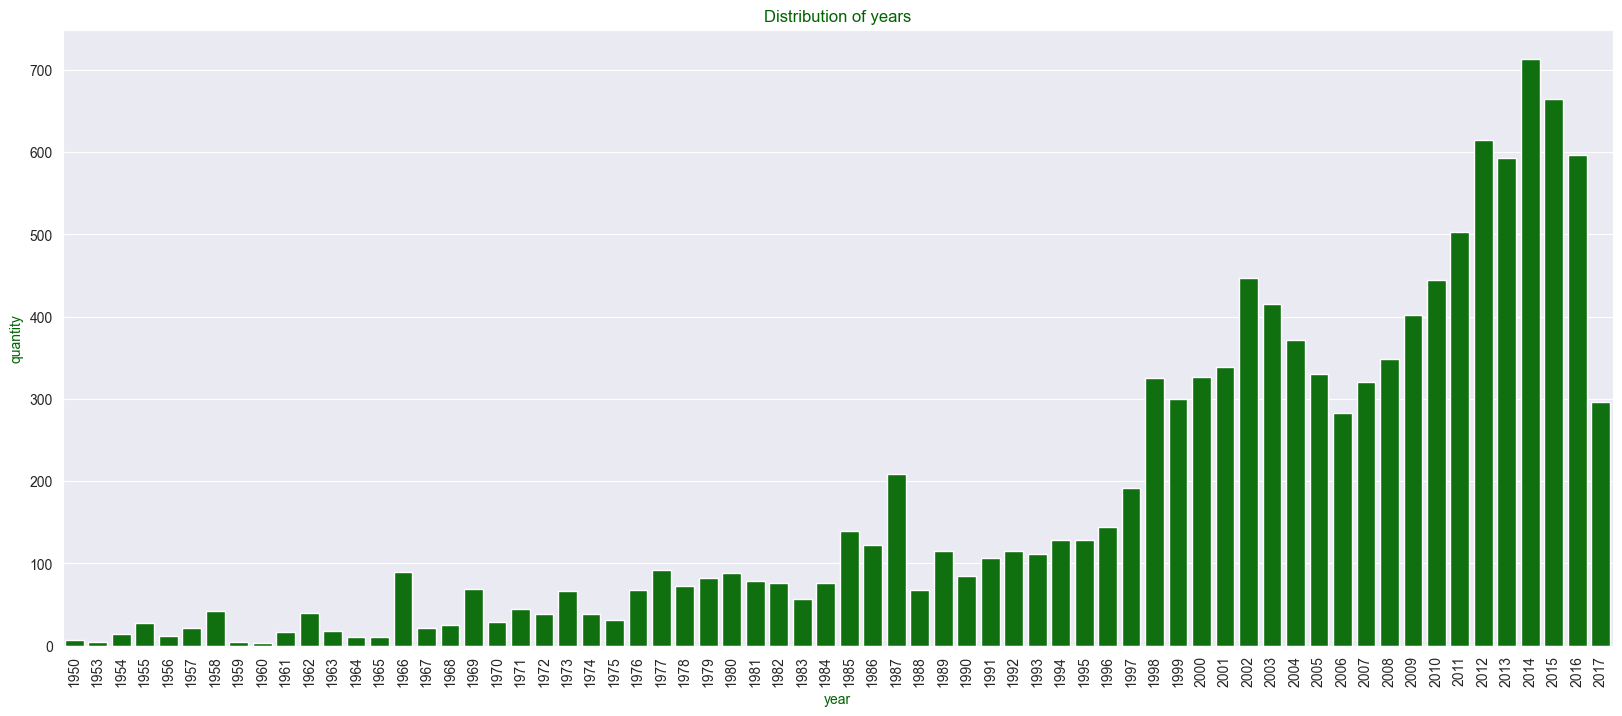

In [12]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title("Distribution of years", color='darkgreen')
ax.set_xlabel('year', color='darkgreen')
ax.set_ylabel('quantity', color='darkgreen')
sns.barplot(x=sets['year'].value_counts().index, y=sets['year'].value_counts().values, color='green', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.show();

As we can see, the range of the year values is betwwen 1950 and 2017.</br>
Now let's proceed to 2nd question

In [13]:
# check the values that can't be converted to int
def check_non_int(data):
    tmp = set()
    for element in data['quantity']:
        if not np.isfinite(element) or not element.is_integer():
            tmp.add(element)
    print(tmp)

check_non_int(inventory_parts)

{-inf}


As we can see there is only the value -inf that is not an integer and because the quantity values must be natural integers we will replace all these -infs with 0. because that's what makes sense. We can't have negative values. In the following code we will do this.

In [14]:
def convert_to_int(value):
    if value == -np.inf:
        return 0
    return int(value)

inventory_parts['quantity'] = inventory_parts['quantity'].apply(convert_to_int)
non_int_values = inventory_parts[~inventory_parts['quantity'].astype(str).str.isdigit()]
print("remaining non integer values:", non_int_values)

remaining non integer values: Empty DataFrame
Columns: [inventory_id, part_id, color_id, quantity, is_spare]
Index: []


Now we calculate the average

In [15]:
print(inventory_parts['quantity'].mean())

2.7670542575540584


c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dan\AppData\Local\Temp\ipykernel_8704\1305912944.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline

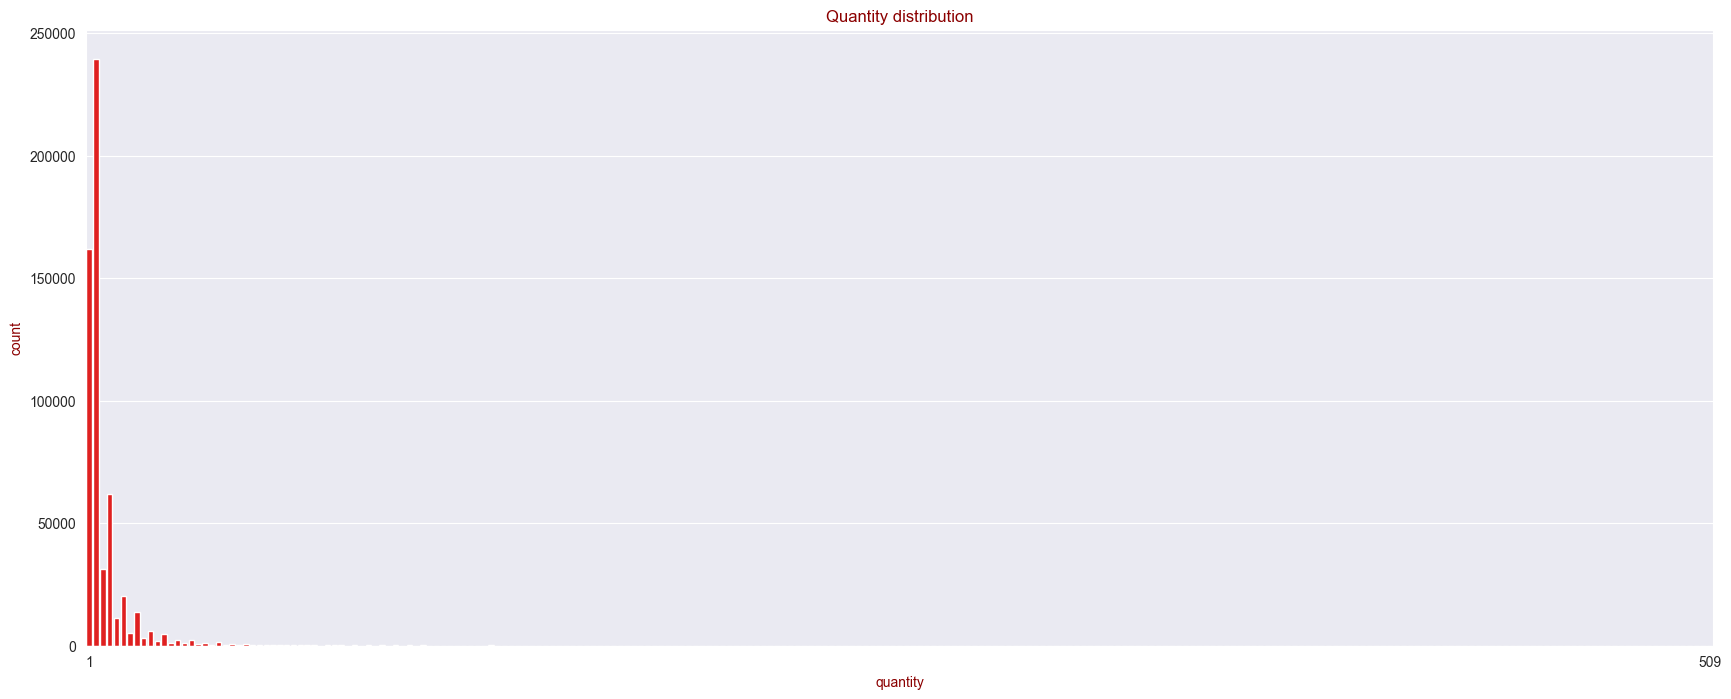

In [16]:
fig1, ax1 = plt.subplots(figsize=(21, 8))
ax1.set_title("Quantity distribution", color='darkred')
ax1.set_xlabel('quantity', color='darkred')
ax1.set_ylabel('count', color='darkred')
sns.barplot(x=inventory_parts['quantity'].value_counts().index, y=inventory_parts['quantity'].value_counts().values, color='red', ax=ax1)
tick_indices = [0, len(inventory_parts['quantity'].value_counts().index) - 1]
ax1.set_xticks(tick_indices)
ax1.set_xticklabels(inventory_parts['quantity'].value_counts().index[tick_indices])
fig1.show();

And yes the data has inconsistency as I told. the fist dataframe that we chacked had so many problems in the year column that we fixed them and said what they are.</br>
For the second dataframe we also saw inconsistencies with the datatype and some of the values.

### 1.3. Querying phase
Answer the following queries using the functionality of `Pandas`:

* List the IDs of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).  

* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).  

* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.  

* Create a scatter plot of the **luminance** of the sets vs their publishing year. After it is done, briefly answer the following questions:
  1. Do you see a trend over the last years?  
  
  2. How do you interpret it?

The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

1- For the first question I will use the themes dataset. After I took a loook at this dataset, I realized that the theme_ids 269 and 112 to 125 are related to car sets. So we will use them to answer this part.

In [17]:
theme_filter = (sets["theme_id"] == 269) | ((sets["theme_id"] >= 112) & (sets["theme_id"] <= 125))
filtered_sets = sets[theme_filter]
ids = [inv for set_id in filtered_sets["id"] for inv in inventory_sets[inventory_sets["set_id"] == set_id]["inventory_id"]]
unique_ids = pd.Series(ids).unique()
print(unique_ids)

[ 2364  1438 10806 14568  9665  2009  1680 11436 12346  5740  6424  3550
 14465  6117 14999 14127  3435]


2- In order to solve this question we will use the parts dataframe to find the 20 highest-quantity part categories, then we will use the part_categories dataset to plot their names.

In [80]:
top_20_id = parts['part_cat_id'].value_counts()[:20]
top_20_id = pd.DataFrame(top_20_id)
top_20_id = top_20_id.merge(part_categories, left_on='part_cat_id', right_on='id')
top_20_id.head()

,count,id,name
0,8556,13,Minifigs
1,2071,27,Minifig Accessories
2,1964,17,Non-LEGO
3,1552,4,"Duplo, Quatro and Primo"
4,1191,10,Tiles Printed


c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dan\AppData\Local\Temp\ipykernel_10156\1587309225.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inlin

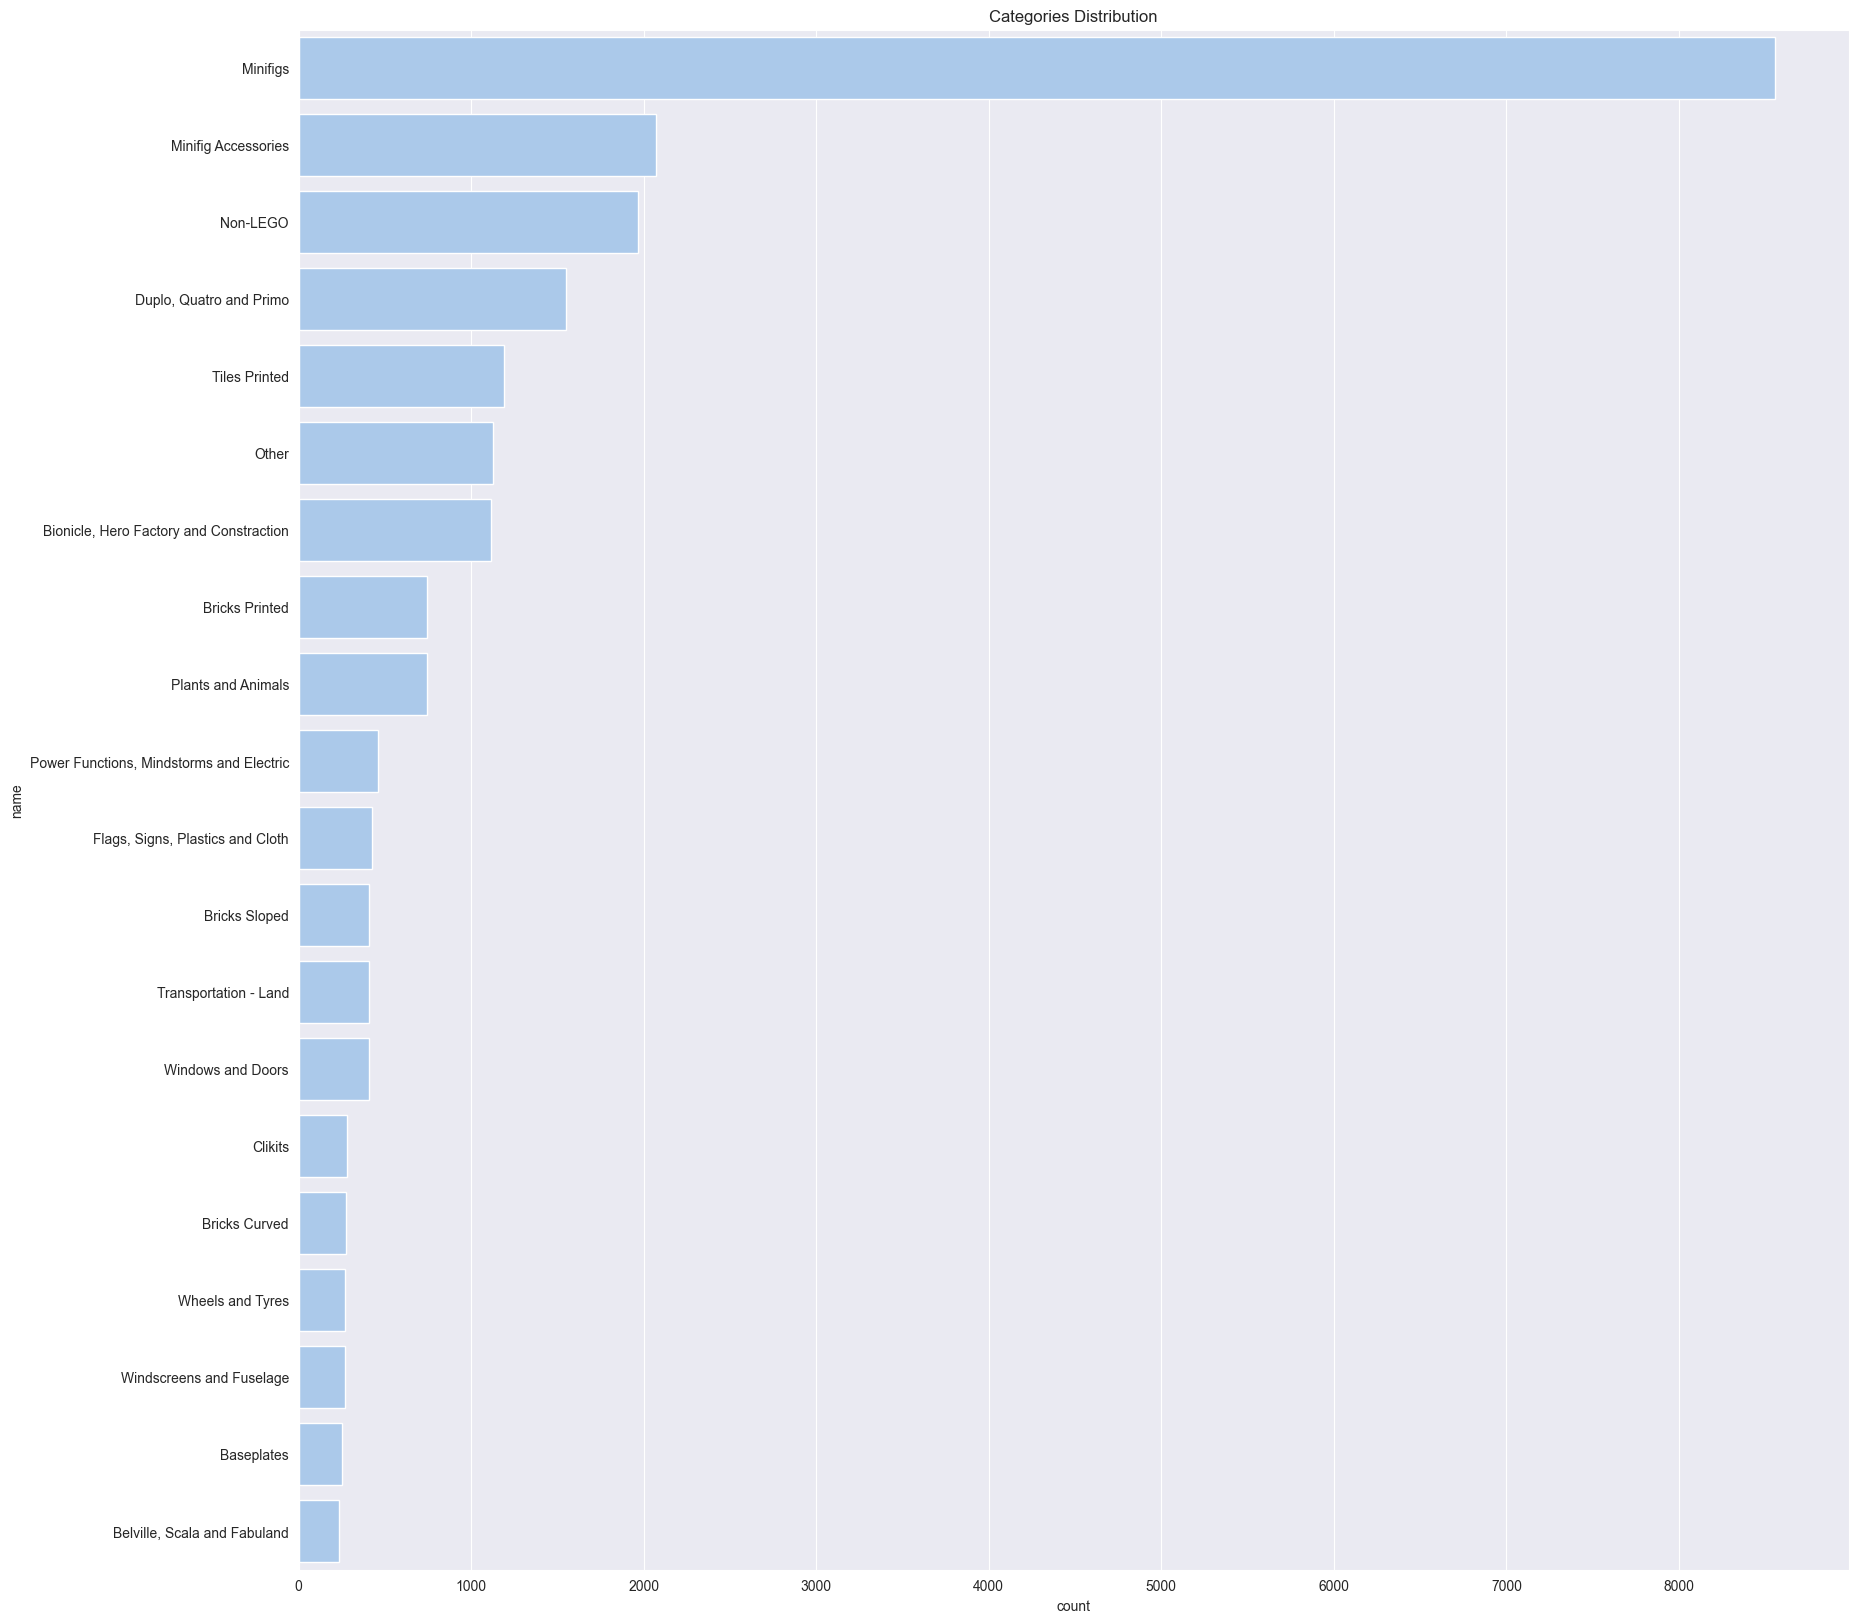

In [81]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title("Categories Distribution")
ax.set_xlabel('quantity')
ax.set_ylabel('category')
sns.set_color_codes("pastel")
sns.barplot(x=top_20_id['count'], y=top_20_id['name'], color='b', orient='h', ax=ax)
fig.show();

3- In order to solve this question, I will get the inventory_id and set_id columns from the inventory_sets dataframe and create a new dataframe with them. Then I will merge them with sets dataframe to add set_name based on id. Then I will use the inventory_id to find the color_id of these sets using inventory_parts dataframe and merge it to the created dataframe. Now I can find the dominant color_id for each set and then use the colors dataframe to get the color and finally plot the results.

In [22]:
df = inventory_sets[['inventory_id', 'set_id']]
df = pd.merge(df, sets[['id', 'name']], left_on='set_id', right_on='id', how='left')
df.drop(columns=['id'], inplace=True)
df = pd.merge(df, inventory_parts[['inventory_id', 'color_id']], how='left')
df.dropna(inplace=True)
color_counts = df.groupby(['set_id', 'color_id']).size().reset_index(name='count')
dominant_color = color_counts.loc[color_counts.groupby('set_id')['count'].idxmax()]
dominant_color = pd.merge(dominant_color, colors[['id', 'rgb', 'name']], left_on='color_id', right_on='id')
df_2_plot = dominant_color[['set_id', 'rgb']]
df_2_plot = df_2_plot.groupby('rgb').size()
df_2_plot = pd.DataFrame(df_2_plot).reset_index()
df_2_plot = pd.merge(df_2_plot, dominant_color[['rgb', 'name']], how='left')
df_2_plot.drop_duplicates(subset='rgb', inplace=True)
df_2_plot.rename(columns={0: "count"}, inplace=True)
df_2_plot.reset_index(inplace=True, drop=True)
df_2_plot

,rgb,count,name
0,0033B2,29,Unknown
1,05131D,73,[No Color]
2,237841,4,Green
3,4C61DB,41,Royal Blue
4,6C6E68,2,Dark Bluish Gray
5,A0A5A9,3,Light Bluish Gray
6,AA7F2E,3,Pearl Gold
7,B48455,6,Flat Dark Gold
8,C91A09,2,Red
9,DBAC34,1,Metallic Gold


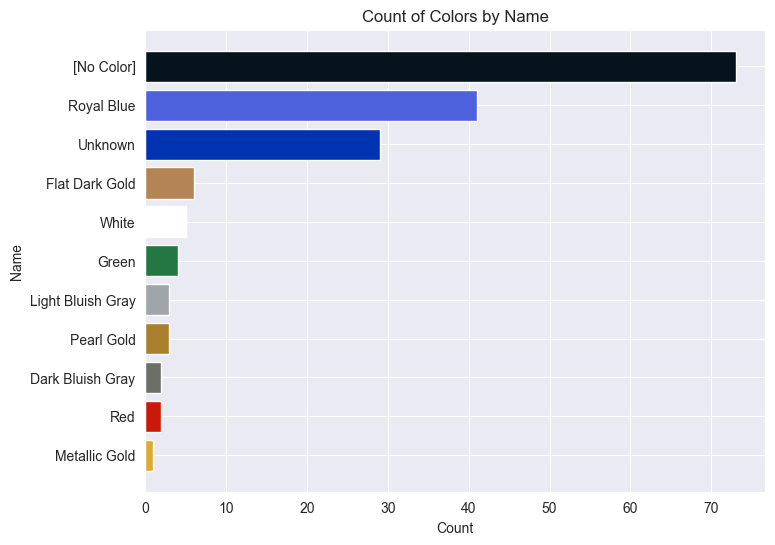

In [23]:
df_2_plot = df_2_plot.sort_values(by='count', ascending=False)
plt.figure(figsize=(8, 6))
plt.barh(df_2_plot['name'], df_2_plot['count'], color='#' + df_2_plot['rgb'])
plt.xlabel('Count')
plt.ylabel('Name')
plt.title('Count of Colors by Name')
plt.gca().invert_yaxis()
plt.show();

4- For this part, first I will create a dataframe that has sets ID and year plus R, G and B values of the dominant color of that year in it. Then I will calculate the luminance and draw the scatter plot.

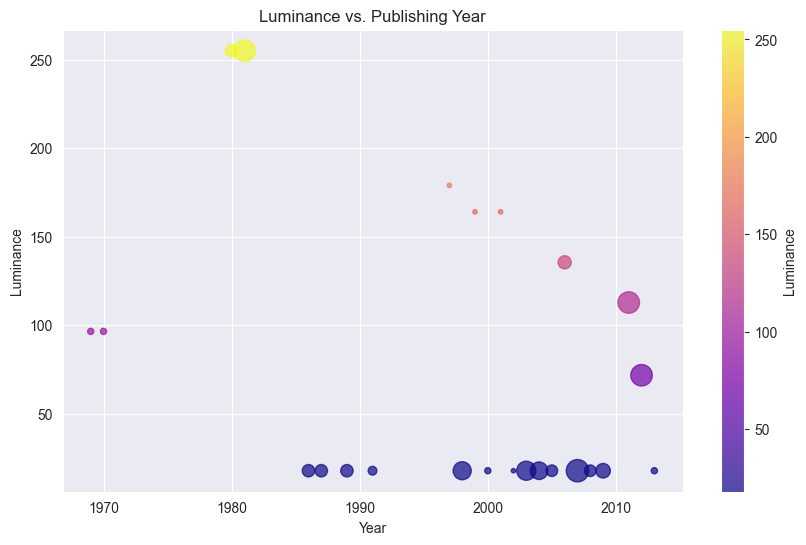

In [37]:
luminance_df = inventory_sets[['inventory_id', 'set_id']]
luminance_df = pd.merge(luminance_df, sets[['id', 'year']], left_on='set_id', right_on='id', how='left')
luminance_df.drop(columns=['id'], inplace=True)
luminance_df = pd.merge(luminance_df, inventory_parts[['inventory_id', 'color_id']], how='left')
luminance_df.dropna(inplace=True)
luminance_df = pd.merge(luminance_df, colors[['id', 'rgb']], left_on='color_id', right_on='id', how='left')
# keeping the required columns only
luminance_df = luminance_df[['year', 'rgb']]
luminance_df = luminance_df.groupby(['year', 'rgb']).size().reset_index(name='count')
l_dom_color = luminance_df.loc[luminance_df.groupby('year')['count'].idxmax()]
l_dom_color.reset_index(inplace=True, drop=True)

# calculating luminance
def split_rgb(rgb):
    r = int(rgb[0:2], 16)
    g = int(rgb[2:4], 16)
    b = int(rgb[4:6], 16)
    return r, g, b

l_dom_color['R'], l_dom_color['G'], l_dom_color['B'] = zip(*l_dom_color['rgb'].map(split_rgb))
l_dom_color['luminance'] = np.sqrt(0.299 * l_dom_color['R'] ** 2 + 0.587 * l_dom_color['G'] ** 2 + 0.114 * l_dom_color['B'] ** 2)

# plotting
plt.figure(figsize=(10, 6))
plt.scatter(l_dom_color['year'], l_dom_color['luminance'], s=l_dom_color['count'] * 10, c=l_dom_color['luminance'], cmap='plasma', alpha=0.7)
plt.title('Luminance vs. Publishing Year')
plt.xlabel('Year')
plt.ylabel('Luminance')
plt.colorbar(label='Luminance')
plt.grid(True)
plt.show();

As we can see, by the passage of time, the luminance has decreased. Which means that the LEGO sets are becoming darker.

## 2. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this question you will again perform data wrangling and interpretation.

### 2.1. Loading phase
Load the json file into a `DataFrame`.


In [4]:
bikes = pd.read_json('./data/bikes/metro-bike-share-trip-data.json')
bikes.head()

,Bike ID,Duration,End Time,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID,Trip Route Category
0,6281.0,180,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,Monthly Pass,30.0,2016-07-07T04:17:00,3014.0,34.056610,-118.23721,1912818,Round Trip
1,6281.0,1980,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,Monthly Pass,30.0,2016-07-07T06:00:00,3014.0,34.056610,-118.23721,1919661,Round Trip
2,5861.0,300,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,Flex Pass,365.0,2016-07-07T10:32:00,3016.0,34.052898,-118.24156,1933383,Round Trip
3,5861.0,10860,2016-07-07T13:38:00,3016.0,34.052898,-118.24156,Flex Pass,365.0,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,1944197,Round Trip
4,6674.0,420,2016-07-07T12:58:00,3032.0,34.049889,-118.25588,Walk-up,0.0,2016-07-07T12:51:00,3032.0,34.049889,-118.25588,1940317,Round Trip


### 2.2. Cleaning phase

Perform the following actions on the dataset.

1. Describe the type and the value range of each attribute.  

2. Indicate and transform the attributes that are `Categorical`.
3. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)?
4. What are the possible pitfalls of having such columns?

Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

First let's get more information from the data

In [5]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Bike ID                     132417 non-null  float64
 1   Duration                    132427 non-null  int64  
 2   End Time                    132427 non-null  object 
 3   Ending Station ID           132331 non-null  float64
 4   Ending Station Latitude     131376 non-null  float64
 5   Ending Station Longitude    131376 non-null  float64
 6   Passholder Type             132427 non-null  object 
 7   Plan Duration               131661 non-null  float64
 8   Start Time                  132427 non-null  object 
 9   Starting Station ID         132408 non-null  float64
 10  Starting Station Latitude   132379 non-null  float64
 11  Starting Station Longitude  132379 non-null  float64
 12  Trip ID                     132427 non-null  int64  
 13  Trip Route Cat

In [6]:
bikes.describe()

,Bike ID,Duration,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Plan Duration,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID
count,132417.000000,132427.000000,132331.00000,131376.000000,131376.000000,131661.000000,132408.000000,132379.000000,132379.000000,1.324270e+05
mean,6193.618878,1555.301562,3042.38672,34.034614,-118.206642,44.821967,3043.020754,34.039309,-118.221534,1.153001e+07
std,293.606755,5814.241813,43.08440,0.650706,2.259913,90.411579,37.742021,0.529336,1.838335,6.369462e+06
min,1349.000000,60.000000,3000.00000,0.000000,-118.472832,0.000000,3000.000000,0.000000,-118.472832,1.912818e+06
25%,5953.000000,360.000000,3022.00000,34.044159,-118.256981,0.000000,3024.000000,34.044170,-118.256980,5.060814e+06
50%,6186.000000,600.000000,3038.00000,34.046810,-118.250954,30.000000,3040.000000,34.046822,-118.250954,1.043827e+07
75%,6434.000000,1080.000000,3063.00000,34.050480,-118.238810,30.000000,3063.000000,34.050880,-118.241562,1.720633e+07
max,6728.000000,86400.000000,4108.00000,34.064281,0.000000,365.000000,4108.000000,34.064281,0.000000,2.379422e+07


We can see the type of each column and the min & max of the numerical columns in the above outputs. 

As we can see, some of the columns are in float, but the don't need to be floats. They can be integers. So fo the first step of the cleaning phase, we will convert them to int. Also we can see that the start and end time of the trips is in the string format (object). So we convert them to datetime.</br>
Moreover, some of the columns have nan values. In this case we will just drop them because they are a small proportion of the data.

In [9]:
bikes.dropna(inplace=True)
colomuns_to_be_converted = ['Bike ID', 'Ending Station ID', 'Starting Station ID']
for col in colomuns_to_be_converted:
    bikes[col] = bikes[col].astype(int)
datetime_cols = ['End Time', 'Start Time']
for col in datetime_cols:
    bikes[col] = pd.to_datetime(bikes[col], format='%Y-%m-%dT%H:%M:%S')
categorical_cols = ['Passholder Type', 'Trip Route Category']
for col in categorical_cols:
    bikes[col] = pd.Categorical(bikes[col])
# check if the changes are applied
bikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130715 entries, 0 to 132426
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Bike ID                     130715 non-null  int32         
 1   Duration                    130715 non-null  int64         
 2   End Time                    130715 non-null  datetime64[ns]
 3   Ending Station ID           130715 non-null  int32         
 4   Ending Station Latitude     130715 non-null  float64       
 5   Ending Station Longitude    130715 non-null  float64       
 6   Passholder Type             130715 non-null  category      
 7   Plan Duration               130715 non-null  float64       
 8   Start Time                  130715 non-null  datetime64[ns]
 9   Starting Station ID         130715 non-null  int32         
 10  Starting Station Latitude   130715 non-null  float64       
 11  Starting Station Longitude  130715 non-

3- Yes we have redundant columns in our dataset. The columns Duration, End Time and Start Time are redundant and 2 of them are enough to describe the time information of a trip.</br>
4- Data redundancy can cause several problems. We can didvide these problems into two main groups:
* Storage problems: we will need more space to store the data and maintaining the data will be hard, because we have to take care of some unnecassary data whenever we want to add or update an entry.</br>
It will also be more time-demanding to do so.
* ML problems: If we want to train an ML model in this dataset, the training time and complexity of the model will increase and chances of overfitting will be higher. So model interpretability will be lower</br>
and we must do feature selection to avoid these problems from happening.

In order to fix this problem we could simply drop one of these columns using .drop function.

In [13]:
bikes_unredundant = bikes.drop(['End Time'], axis=1)
bikes_unredundant.head(5)

,Bike ID,Duration,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID,Trip Route Category
0,6281,180,3014,34.056610,-118.23721,Monthly Pass,30.0,2016-07-07 04:17:00,3014,34.056610,-118.23721,1912818,Round Trip
1,6281,1980,3014,34.056610,-118.23721,Monthly Pass,30.0,2016-07-07 06:00:00,3014,34.056610,-118.23721,1919661,Round Trip
2,5861,300,3016,34.052898,-118.24156,Flex Pass,365.0,2016-07-07 10:32:00,3016,34.052898,-118.24156,1933383,Round Trip
3,5861,10860,3016,34.052898,-118.24156,Flex Pass,365.0,2016-07-07 10:37:00,3016,34.052898,-118.24156,1944197,Round Trip
4,6674,420,3032,34.049889,-118.25588,Walk-up,0.0,2016-07-07 12:51:00,3032,34.049889,-118.25588,1940317,Round Trip


### 2.3. Querying phase
Answer the following queries using the functionality of `Pandas`.

* Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).  

* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*.</br> What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*.</br>
Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more</br>
complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

C:\Users\99661110\AppData\Local\Temp\ipykernel_21284\3975683657.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


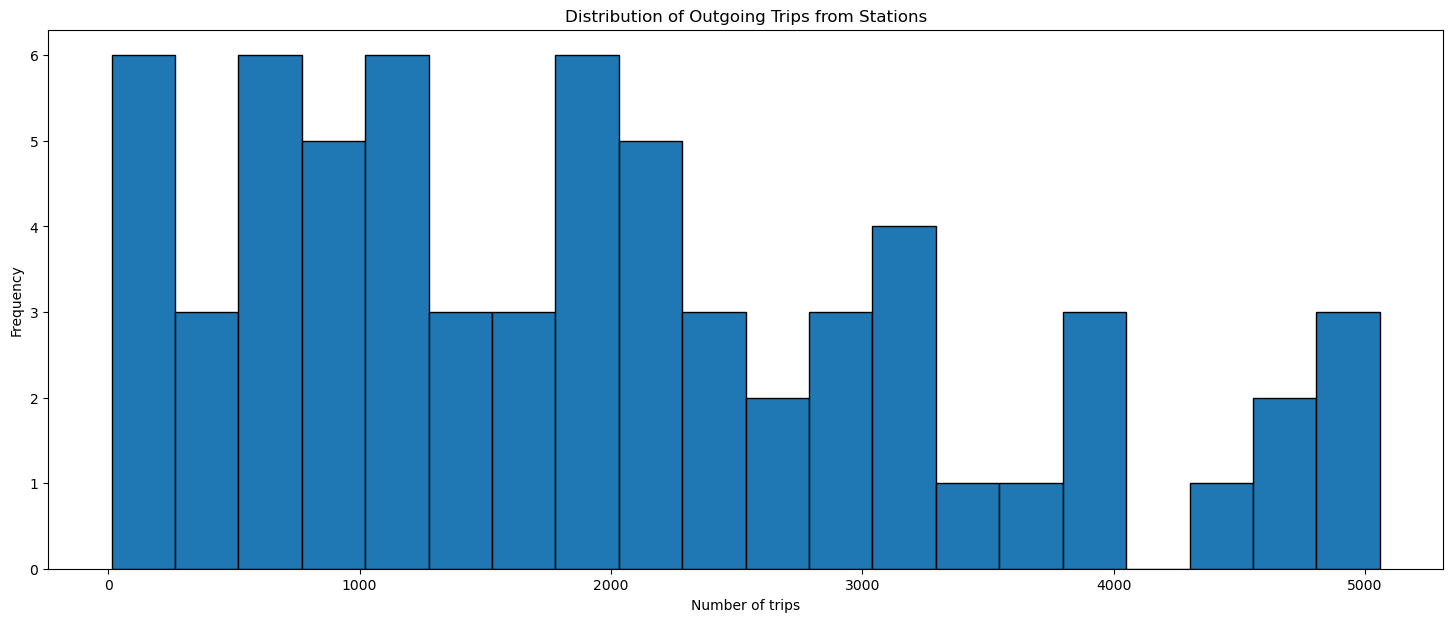

In [20]:
outgoing_trips = bikes.groupby('Starting Station ID').size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(18, 7))
ax.hist(outgoing_trips['count'], bins=20, edgecolor='k')
ax.set_xlabel("Number of trips")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Outgoing Trips from Stations")
fig.show();

C:\Users\99661110\AppData\Local\Temp\ipykernel_21284\403065806.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


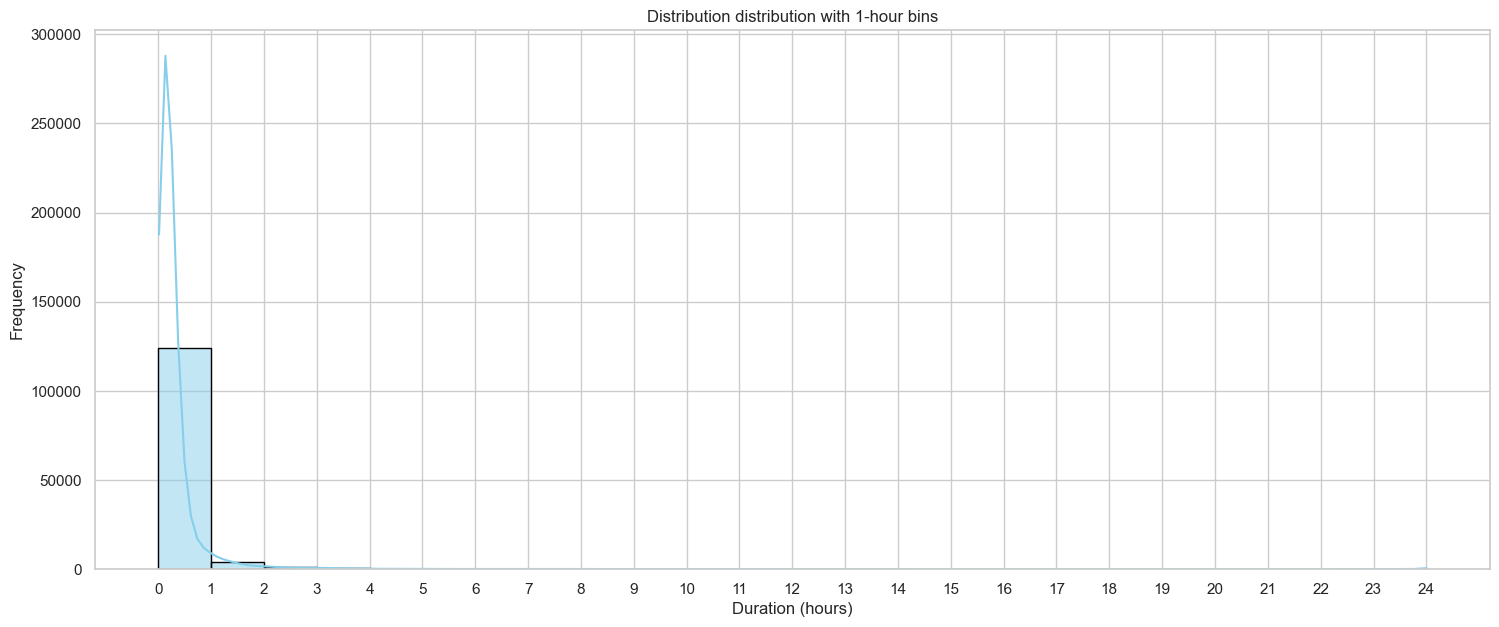

In [81]:
duriation_hours = bikes['Duration']/3600
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(18, 7))
sns.histplot(duriation_hours, bins=range(0, 25), kde=True, color='skyblue', edgecolor='black')
ax.set_xlabel("Duration (hours)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution distribution with 1-hour bins")
ax.set_xticks(range(0, 25))
fig.show();

As we can see, a great proportion of trips take less than 1 hour. The second most observed duration is between 1 and 2 hours. Which makes sense because most of the bike trips are short trips and shouldn't be longer than an hour.

C:\Users\99661110\AppData\Local\Temp\ipykernel_21284\3497690156.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


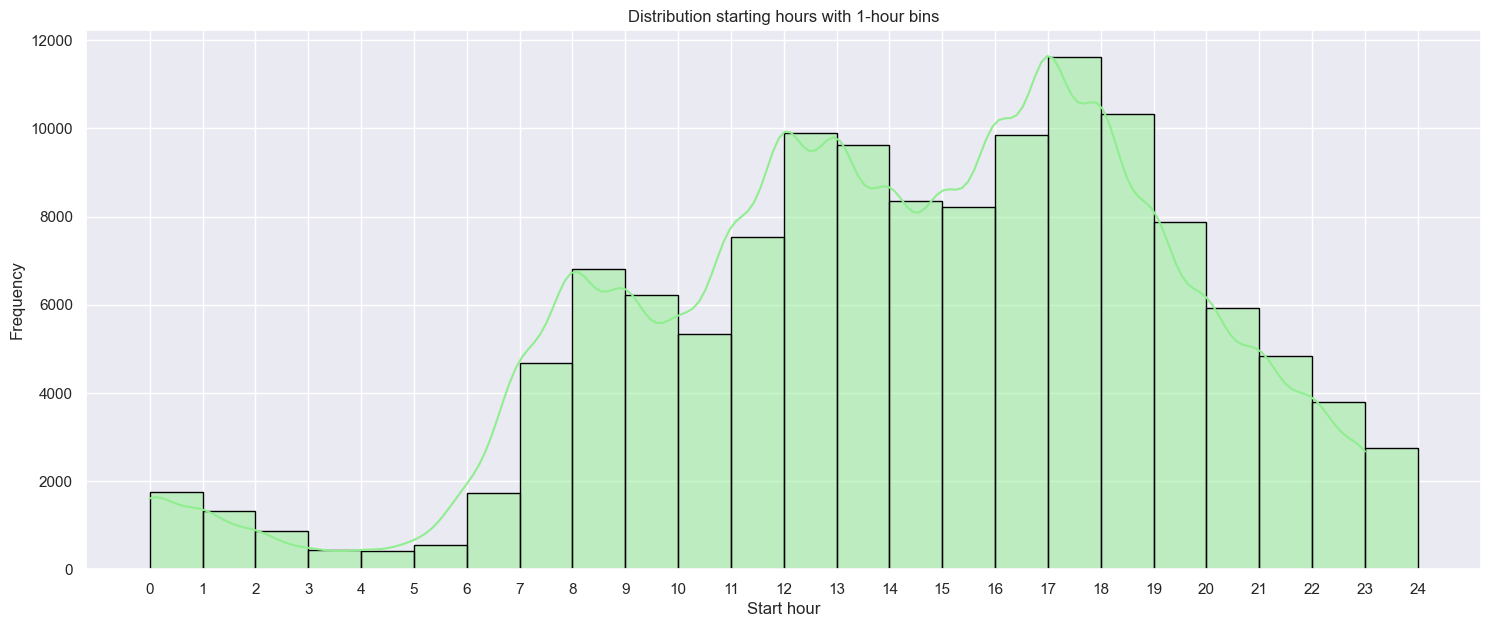

In [82]:
starting_hours = bikes['Start Time'].dt.hour
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(18, 7))
sns.histplot(starting_hours, bins=range(0, 25), kde=True, color='lightgreen', edgecolor='black')
ax.set_xlabel("Start hour")
ax.set_ylabel("Frequency")
ax.set_title("Distribution starting hours with 1-hour bins")
ax.set_xticks(range(0, 25))
fig.show();

As we can see, the local maximas are 0, 8, 12 and 17. These are the most popular hours to start a bike trip. Ofcourse the first one (0) is the least frequent one because most people are sleeping on that time</br>
and maybe some with specific intentions and hobbies (like late night ride) go for a bike trip on that hour. For the second local maxima (8), we can infer that they are mostly shop owners or people who want to</br>
some exercise that go for a bike trip at 8 pm. Afterwards, the next local maxima is 12, which is probably the trasportations relating to launch or food-relating stuff (I don't know what exactly it is. It must be checked using relavant data)</br>
and finaly the last local and global maxima ocurs at 5 pm, which is because people are eighther getting back from work or starting a bike trip as a hobby.

C:\Users\99661110\AppData\Local\Temp\ipykernel_21284\1247635387.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


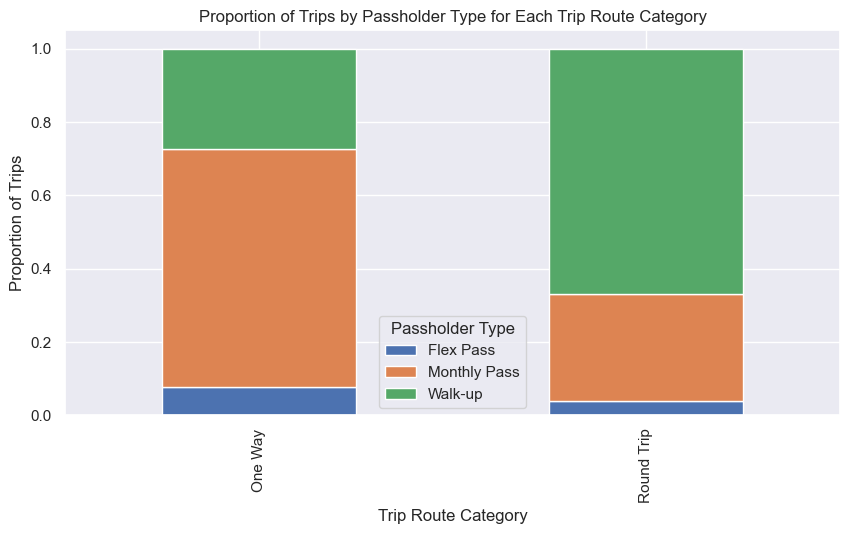

In [44]:
trip_proportion = bikes.groupby(['Trip Route Category', 'Passholder Type']).size().reset_index(name='count')
trip_proportion['count_normalized'] = trip_proportion.groupby('Trip Route Category')['count'].transform(lambda x: x / x.sum())
trip_proportion.drop('count', inplace=True, axis=1)
pivot_trip = trip_proportion.pivot(index='Trip Route Category', columns='Passholder Type', values='count_normalized')
fig, ax = plt.subplots(figsize=(10, 5));
pivot_trip.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Trip Route Category')
ax.set_ylabel('Proportion of Trips')
ax.set_title('Proportion of Trips by Passholder Type for Each Trip Route Category')
fig.show();

C:\Users\99661110\AppData\Local\Temp\ipykernel_21284\1197854728.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


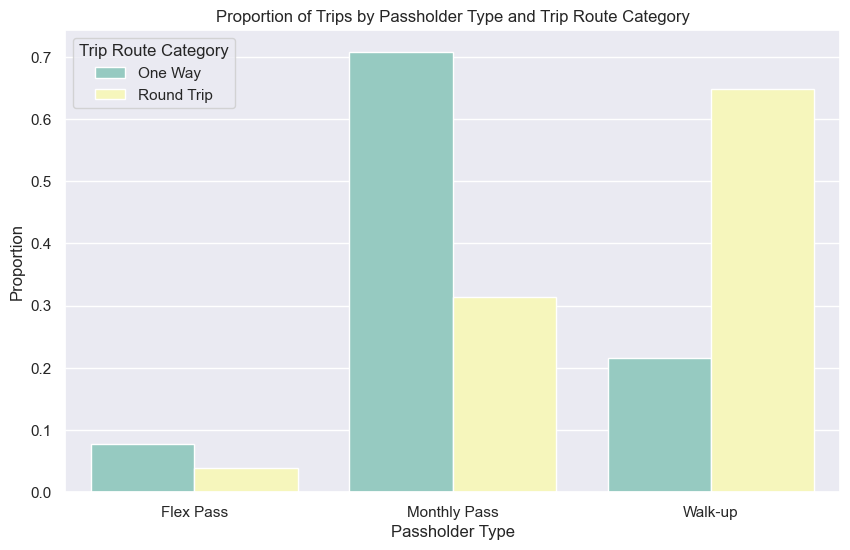

In [88]:
morning_trips = bikes[bikes['Start Time'].dt.time <= datetime.time(12, 0, 0)]
groups = morning_trips.groupby(['Trip Route Category', 'Passholder Type']).size().reset_index(name='count')
groups['proportion'] = groups.groupby('Trip Route Category')['count'].transform(lambda x: x/ x.sum())
groups.drop('count', inplace=True, axis=1)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="Passholder Type", y="proportion", hue="Trip Route Category", data=groups, palette="Set3", ax=ax)
ax.set_title('Proportion of Trips by Passholder Type and Trip Route Category')
ax.set_xlabel('Passholder Type')
ax.set_ylabel('Proportion')
ax.legend(title='Trip Route Category')
fig.show();

As we can see, for the Round Trip category the Flex Pass type is only a very small part of it. This is also the case for the One way category.</br>
So we can infer that the Flex Pass category is kind of the oulier here, because its proportion is small. However we can't remove it from data</br>
because it gives good insight and is necessary for analyzing the data.

In [107]:
# finding the dividing hour
df = bikes[['Start Time', 'Trip Route Category', 'Passholder Type']]
df['hour'] = df['Start Time'].dt.hour
df.drop('Start Time', axis=1, inplace=True)
hour_counts = df['hour'].value_counts().sort_index()
total_trips = hour_counts.sum()
trips_till_now = 0
dividing_hour = None
best_diff = total_trips
for h, c in hour_counts.items():
    trips_till_now += c
    diff = abs(total_trips/2 - trips_till_now)
    if diff < best_diff:
        best_diff = diff
        dividing_hour = h

# creating the final dataframe
df['category'] = df['hour'].apply(lambda x: 1 if x < dividing_hour else 2)
group = df.groupby(['Trip Route Category', 'Passholder Type', 'category']).size().reset_index(name='count')
group['proportion'] = group.groupby('Trip Route Category')['count'].transform(lambda x: x/ x.sum())
group.drop('count', axis=1, inplace=True)
group

C:\Users\99661110\AppData\Local\Temp\ipykernel_21284\4056440349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['Start Time'].dt.hour
C:\Users\99661110\AppData\Local\Temp\ipykernel_21284\4056440349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Start Time', axis=1, inplace=True)
C:\Users\99661110\AppData\Local\Temp\ipykernel_21284\4056440349.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Trip Route Category,Passholder Type,category,proportion
0,One Way,Flex Pass,1,0.033908
1,One Way,Flex Pass,2,0.042089
2,One Way,Monthly Pass,1,0.294742
3,One Way,Monthly Pass,2,0.355767
4,One Way,Walk-up,1,0.108652
5,One Way,Walk-up,2,0.164842
6,Round Trip,Flex Pass,1,0.017654
7,Round Trip,Flex Pass,2,0.020583
8,Round Trip,Monthly Pass,1,0.137191
9,Round Trip,Monthly Pass,2,0.155953


In [108]:
dividing_hour

14

As we can see, the proportion actually differs based on the category, which means there is a difference between these two time intervals.</br>
Overally, the proportion is higher in the second interval for all the categories. So yes, the company will gain more benefit, if they increase</br>
the rent after 2 pm. So if they apply this for monthly-pass users, they will gain a benefit. However it is obvious that they shouldn't decrease</br>
the prices for the first interval so much. Because for the monthly-pass users the difference is not much.

## 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

**Run the following cell for a brief description about the dataset**

In [38]:
from IPython.core.display import HTML
HTML(filename='./data/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`.  
 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [39]:
titanic = pd.read_excel('data/titanic.xls')
titanic.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


1- We can see the type and value range of each attribute using the following commands. Although we can draw plots of them, but these tables give a great amount of information and insight in just a small space.

In [40]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [42]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


The columns survived and sex can be categorical. So we will convert them.

In [43]:
categorical_cols = ['sex', 'survived']
for col in categorical_cols:
    titanic[col] = pd.Categorical(titanic[col])

2- We will just plot the histograms. There is nothing to explain :)

C:\Users\Dan\AppData\Local\Temp\ipykernel_8704\2617684814.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


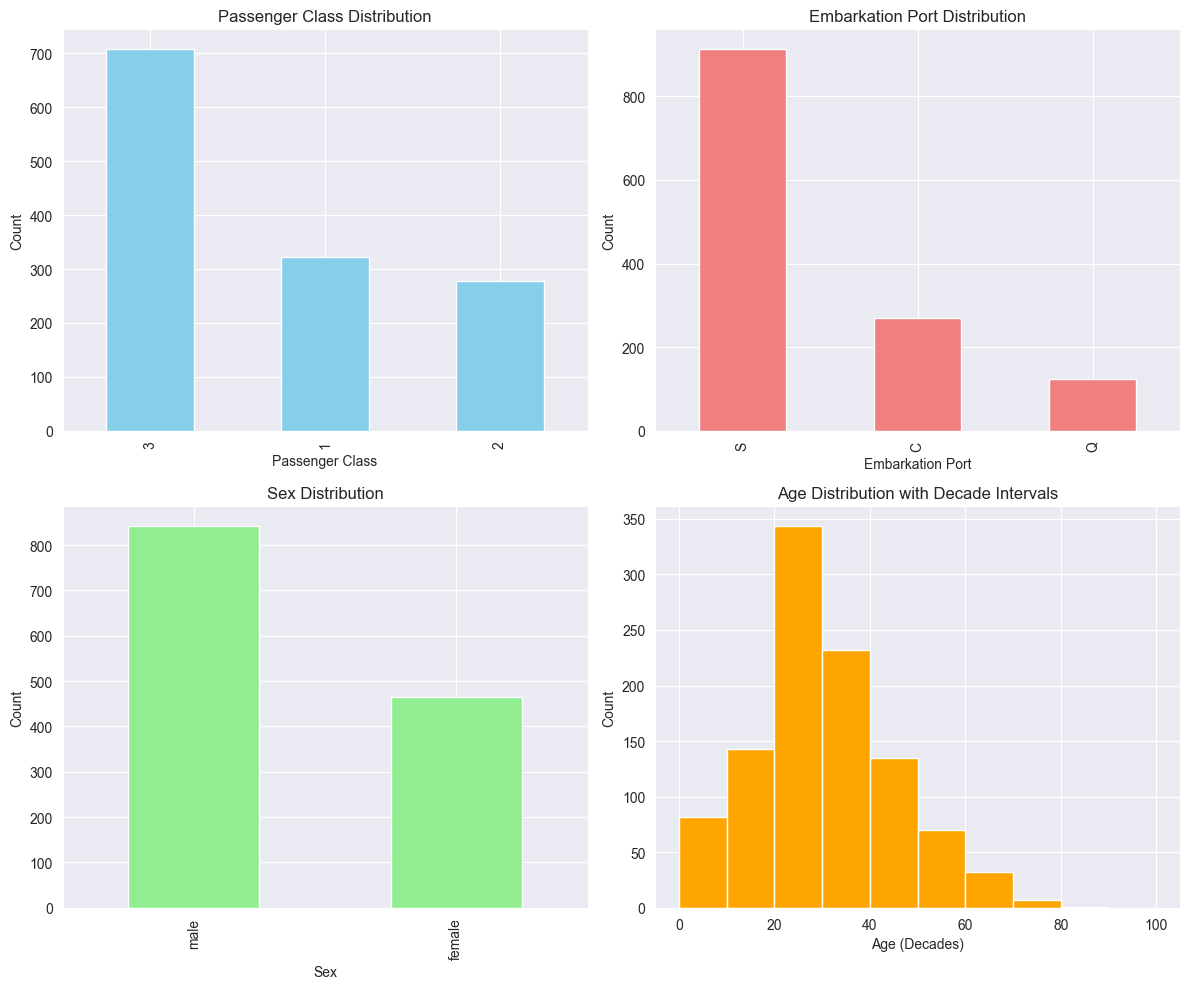

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Passenger Class Distribution
titanic['pclass'].value_counts().plot(kind='bar', color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Passenger Class Distribution')
axes[0, 0].set_xlabel('Passenger Class')
axes[0, 0].set_ylabel('Count')

# Embarkation Port Distribution
titanic['embarked'].value_counts().plot(kind='bar', color='lightcoral', ax=axes[0, 1])
axes[0, 1].set_title('Embarkation Port Distribution')
axes[0, 1].set_xlabel('Embarkation Port')
axes[0, 1].set_ylabel('Count')

# Sex Distribution
titanic['sex'].value_counts().plot(kind='bar', color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Sex Distribution')
axes[1, 0].set_xlabel('Sex')
axes[1, 0].set_ylabel('Count')

# Age Distribution with Decade Intervals
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
titanic['age'].plot.hist(bins=age_bins, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Age Distribution with Decade Intervals')
axes[1, 1].set_xlabel('Age (Decades)')
axes[1, 1].set_ylabel('Count')

fig.tight_layout()
fig.show();

3- First we will use regex to extract the cabin floor from the cabin values and then we will draw the pie chart.

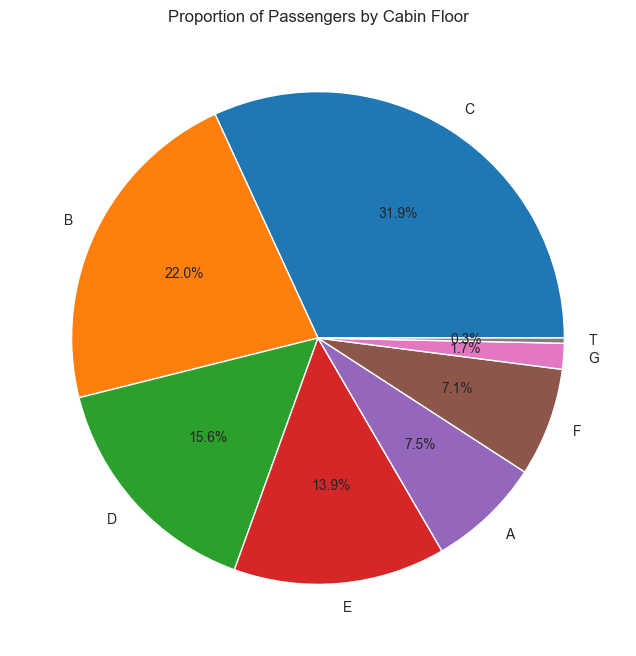

In [51]:
titanic['cabin'] = titanic['cabin'].str.extract(r'([A-Z])')
floor_counts = titanic['cabin'].value_counts()
proportions = floor_counts / len(titanic)

plt.figure(figsize=(8, 8))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%')
plt.title('Proportion of Passengers by Cabin Floor')
plt.show()

4- I will use a 1*3 grid to draw the pie charts.

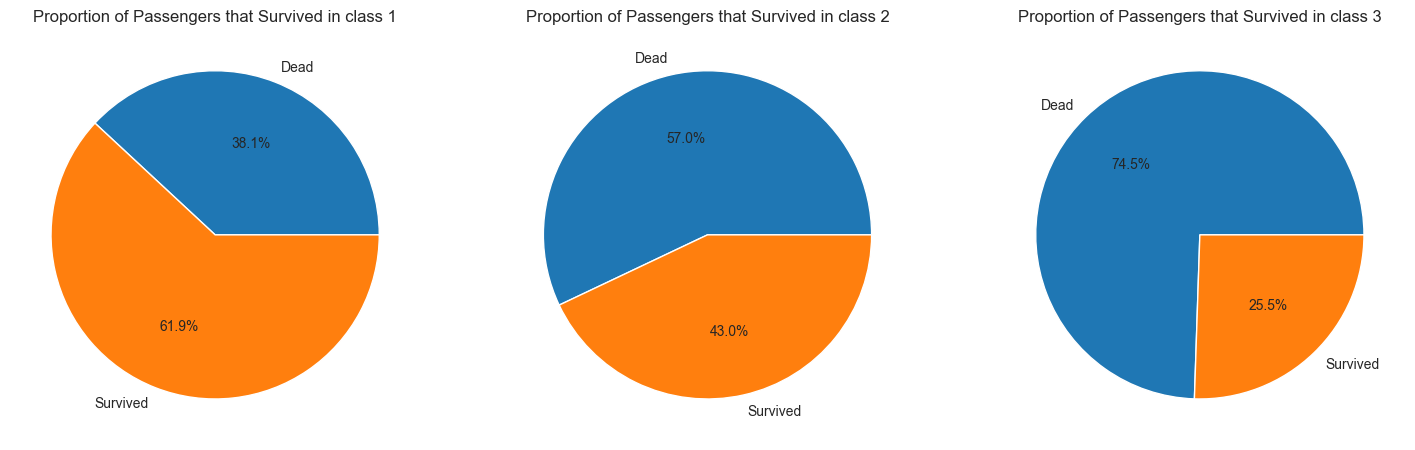

In [53]:
class_survival_counts = titanic.groupby('pclass')['survived'].value_counts().unstack().fillna(0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (p_class, proportions) in enumerate(class_survival_counts.iterrows()):
    labels = ['Dead', 'Survived']
    ax = axes[i]
    ax.pie(proportions, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Proportion of Passengers that Survived in class {p_class}')

plt.show()

5- I will just plot the histogram.

C:\Users\Dan\AppData\Local\Temp\ipykernel_8704\1602163703.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = titanic.groupby(['pclass', 'sex', 'survived'])['survived'].size().unstack()


<Figure size 1200x600 with 0 Axes>

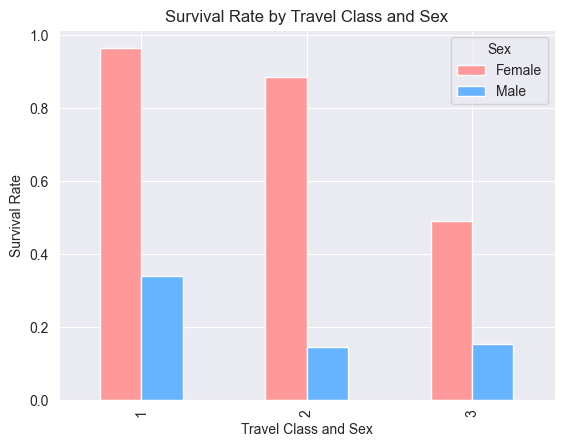

In [64]:
proportions = titanic.groupby(['pclass', 'sex', 'survived'])['survived'].size().unstack()

proportions['survive rate'] = proportions[1] / (proportions[0] + proportions[1])
plt.figure(figsize=(12, 6))
proportions['survive rate'].unstack().plot(kind='bar', color=colors)
plt.title('Survival Rate by Travel Class and Sex')
plt.xlabel('Travel Class and Sex')
plt.ylabel('Survival Rate')
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.show();

6- Firstly I will create 2 equal parts from the dataframe. Then I will group the entities by the given columns and create the final dataframe.

In [79]:
titanic['Age Category'] = pd.qcut(titanic['age'], q=2)
result = titanic.groupby(['Age Category', 'pclass', 'sex', 'survived'])['survived'].count().unstack().fillna(0)
result.rename(columns={0: 'Dead', 1: 'Survived'}, inplace=True)
result['Survived Proportion'] = result['Survived'] / (result['Dead'] + result['Survived'])
result['Dead Proportion'] = result['Dead'] / (result['Dead'] + result['Survived'])
result.drop(['Survived', 'Dead'], axis=1, inplace=True)
result.reset_index(inplace=True)
result

C:\Users\Dan\AppData\Local\Temp\ipykernel_8704\298436987.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = titanic.groupby(['Age Category', 'pclass', 'sex', 'survived'])['survived'].count().unstack().fillna(0)


survived,Age Category,pclass,sex,Survived Proportion,Dead Proportion
0,"(0.166, 28.0]",1,female,0.951220,0.048780
1,"(0.166, 28.0]",1,male,0.531250,0.468750
2,"(0.166, 28.0]",2,female,0.910714,0.089286
3,"(0.166, 28.0]",2,male,0.216216,0.783784
4,"(0.166, 28.0]",3,female,0.513761,0.486239
5,"(0.166, 28.0]",3,male,0.183036,0.816964
6,"(28.0, 80.0]",1,female,0.967391,0.032609
7,"(28.0, 80.0]",1,male,0.302521,0.697479
8,"(28.0, 80.0]",2,female,0.872340,0.127660
9,"(28.0, 80.0]",2,male,0.083333,0.916667


## Bonus. Covid in the US
In this question, you are required to reproduce the graphs shown in a real journalistic article. After all, reproducibility is an important part of professional journalism as well as data science. Also, a great deal of a data scientist's work is to communicate data in a way that anyone with any level of expertise in the field would understand.

You should reproduce the 4 graphs shown in <a href="https://projects.fivethirtyeight.com/coronavirus-polls/"> this article</a>. The data is openly accessible through <a href="https://github.com/fivethirtyeight/covid-19-polls/"> FiveThirtyEight's github</a>. Nevertheless, both the data and the article are available in `data` folder in case of unstable internet connections!

*Note: Your graphs don't have to be as interactive or detailed as the ones on the website. Only showing the averages, some (not all) data points with light color, legends, titles, x values, and y values are necessary.*

**Explain your approach and assumptions once this section is completed.**